<b>For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book.For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.Stary by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set.</b>

In [1]:
# import dependencies
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load train dataset. Had to use sample of train dataset because unable to use full data(huge file - 4gb)
filename = 'train.csv'
n = sum(1 for line in open(filename)) - 1
s = 150000
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip)

In [3]:
#load destination dataset
dest = pd.read_csv('destinations.csv')

### Exploratory Data Analysis

In [4]:
#description of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  150000 non-null  object 
 1   site_name                  150000 non-null  int64  
 2   posa_continent             150000 non-null  int64  
 3   user_location_country      150000 non-null  int64  
 4   user_location_region       150000 non-null  int64  
 5   user_location_city         150000 non-null  int64  
 6   orig_destination_distance  96047 non-null   float64
 7   user_id                    150000 non-null  int64  
 8   is_mobile                  150000 non-null  int64  
 9   is_package                 150000 non-null  int64  
 10  channel                    150000 non-null  int64  
 11  srch_ci                    149797 non-null  object 
 12  srch_co                    149797 non-null  object 
 13  srch_adults_cnt            15

In [5]:
# Create a hostel cluster ranking based on highest count
hotel_cluster_ranking = df['hotel_cluster'].value_counts()
#display 5 hostel cluster ranking based on highest count
hotel_cluster_ranking.head()

91    4192
41    3094
48    2976
64    2797
65    2621
Name: hotel_cluster, dtype: int64

In [6]:
#drop unnecessary columns, columns which are not useful in analysis and prediction.
#We are to predict which “hotel cluster” the user is likely to book, given his (or her) search details.Not all columns are adequate.
df = df.drop(['date_time','site_name', 'user_id','srch_ci', 'srch_co'], axis=1)

#### Drop null or missing values

In [7]:
df.shape

(150000, 19)

In [8]:
#drop na values
df = df.dropna()

In [9]:
df.shape

(96047, 19)

#### Data Analysis

Text(0.5, 6.79999999999999, 'Hotel Cluster')

<Figure size 864x1008 with 0 Axes>

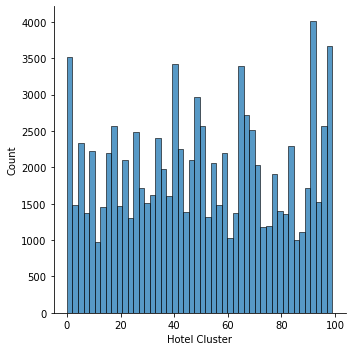

In [10]:
#hotel cluster histogram using seaborn
plt.figure(figsize=(12,14))
sns.displot(df['hotel_cluster'])
plt.xlabel("Hotel Cluster")

#### Plot user location based on bookings on the hotel or a visitor to the hotel website

Text(0.5, 0, 'User location country')

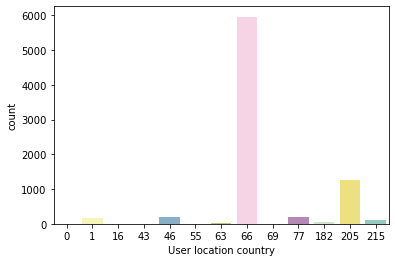

In [11]:
# bookings on the hotel based on user location
bookings_df = df[df["is_booking"] == 1]
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),palette="Set3")
plt.xlabel("User location country")

Text(0.5, 0, 'Original Destination Distance')

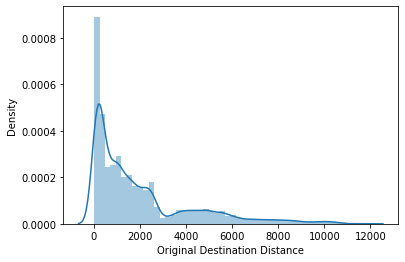

In [12]:
#Histogram for physical distance between a hotel and a customer at the time of search.
sns.distplot(df["orig_destination_distance"].dropna())
plt.xlabel("Original Destination Distance")

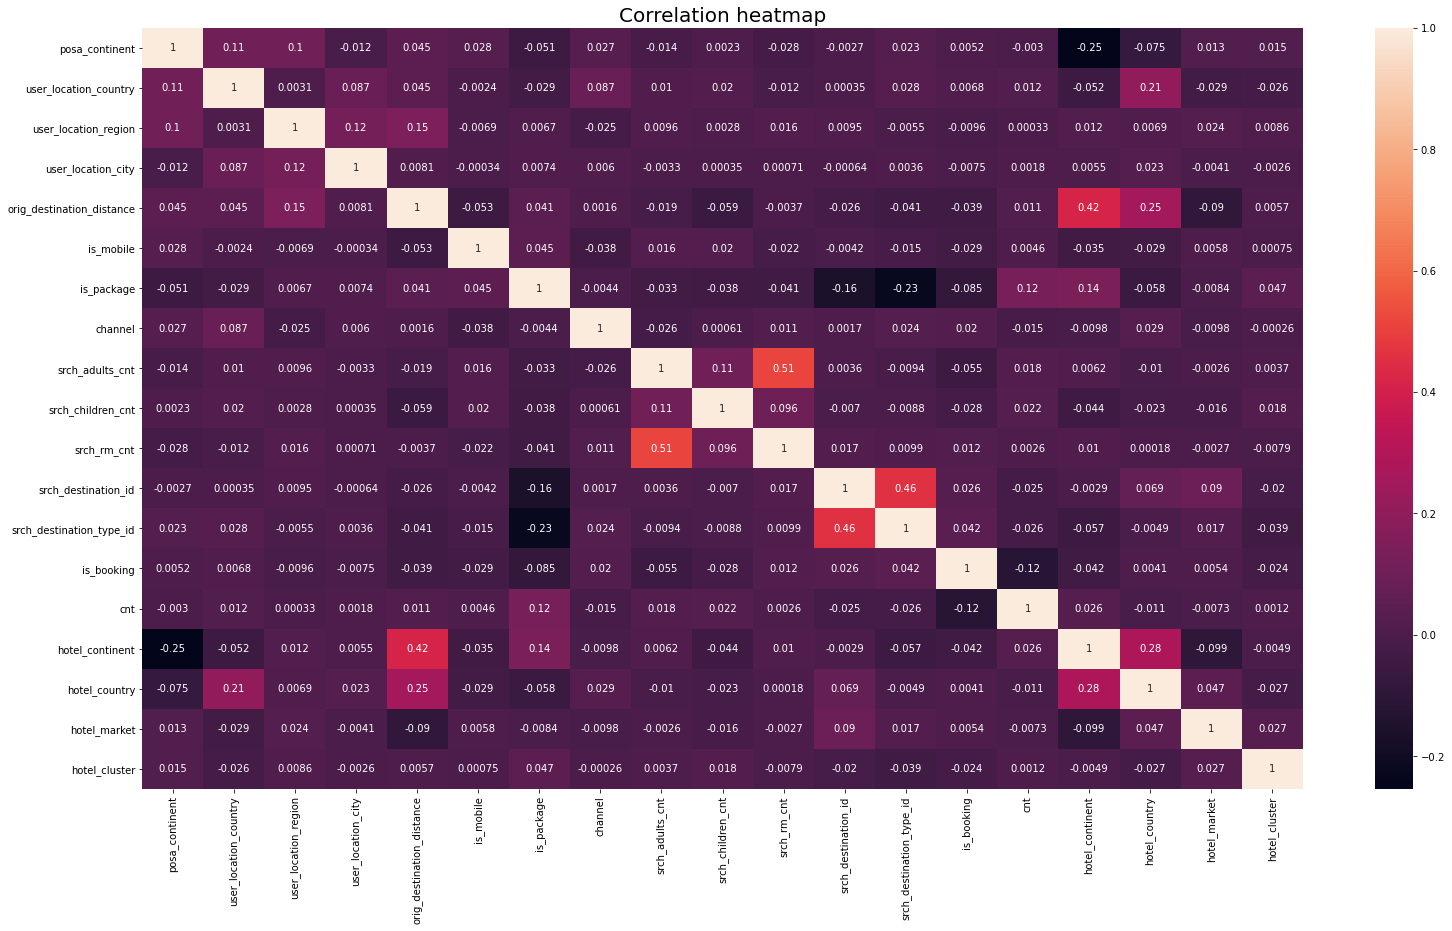

In [13]:
#create heatmap to find correlation
plt.figure(figsize =(26,14))
dfMatrix = df.corr()
sns.heatmap(dfMatrix, annot = True)
plt.title('Correlation heatmap', fontsize = 20)
plt.show()

In [14]:
#merge random sampled train dataset with destination dataset on unique id srch_destination_id
df = df.merge(dest, how= 'left', on ='srch_destination_id')

In [15]:
# Groupby search, country and market to help determine cluster
predictor = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
concat_predictor = pd.concat(predictor).groupby(level=[0,1,2,3]).sum()
#drop na(inplace=True)
concat_predictor.dropna(inplace= True)

In [16]:
# Create sum and count column in the groupby table
concat_predictor['sum_and_count'] = 0.85*concat_predictor['sum'] + 0.15*concat_predictor['count']
concat_predictor = concat_predictor.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
concat_predictor.reset_index(inplace=True)

#create pivot table with above columns
pivot = concat_predictor.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_count').reset_index()

In [17]:
#merge train,destination dataset with pivot table
df = pd.merge(df, pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
#fill na with 0
df.fillna(0, inplace=True)
#check shape of dataframe
df.shape

(96047, 268)

In [18]:
# Only retain booking transaction. 0 is click on website vs 1 is for booking hotel.
df = df[df['is_booking'] == 1]

### For model, we used hotel cluster as the target column

In [19]:
#Setting predictor variable,the variable that helps predict the value of the output variable.
X = df.drop(['hotel_cluster','is_booking'] , axis=1)
#Setting target variable,the variable that we want to predict
y = df['hotel_cluster'] 

### Machine Learning Model

In [20]:
# Divide into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =33)

### Gaussian Naive Bayes classifier

In [21]:
gnb = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
# Fit the classifier to the data
gnb.fit(X_train, y_train)
# Check the accuracy
gnn_classifier = gnb.score(X_test, y_test)
print('Accuracy for Gaussian Naive Bayes classifier model is:',gnn_classifier)

Accuracy for Gaussian Naive Bayes classifier model is: 0.11362209667294414


### KNN classifier

In [22]:
knn_classifier = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=3))
# Fit the classifier to the data
knn_classifier.fit(X_train,y_train)
# Check the accuracy
knn_accuracy = knn_classifier.score(X_test, y_test)
print('Accuracy for KNN classifier model is:',knn_accuracy)

Accuracy for KNN classifier model is: 0.29315756434400503


### K-Nearest Neighbor Classifier

In [23]:
# K-Nearest Neighbor Classifier
knneighbor_clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=6))
#Check the accuracy
knn_classifier = np.mean(cross_val_score(knneighbor_clf, X, y, cv=10, scoring='accuracy'))
print('Accuracy for K-Nearest Neighbor Classifier model is:',knn_classifier)

Accuracy for K-Nearest Neighbor Classifier model is: 0.33764682887461145
